# Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

In [173]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

def calibrate_camera():
    
    # number of squares in x axis
    nx = 9
    # number of squares in y axis
    ny = 6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob("./camera_cal/calibration*.jpg")
    print("Reading images for calibration...")
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        print("Finding corners on ", fname, "...")
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            just_file_name = fname.split("/")[-1]
            print("Writing to corners_found...")
            cv2.imwrite(os.path.join("./camera_cal/corners_found/", just_file_name), img)
    
    # Get image size
    img_size = (img.shape[1],img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Save the camera calibration result for later process
    print("Saving the parameter to file: camera_cal/camera_cal.p")
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle_file = open("./camera_cal/camera_cal.p", "wb")
    pickle.dump(dist_pickle, pickle_file)
    pickle_file.close()
    
calibrate_camera()

Reading images for calibration...
Finding corners on  ./camera_cal/calibration5.jpg ...
Finding corners on  ./camera_cal/calibration4.jpg ...
Finding corners on  ./camera_cal/calibration6.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration7.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration3.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration2.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration1.jpg ...
Finding corners on  ./camera_cal/calibration20.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration19.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration18.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration15.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration14.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration16.jpg ...
Writin

A test to undistort a image

Reading the camera calibration parameters...
Reading the sample image...
Visulize the result...


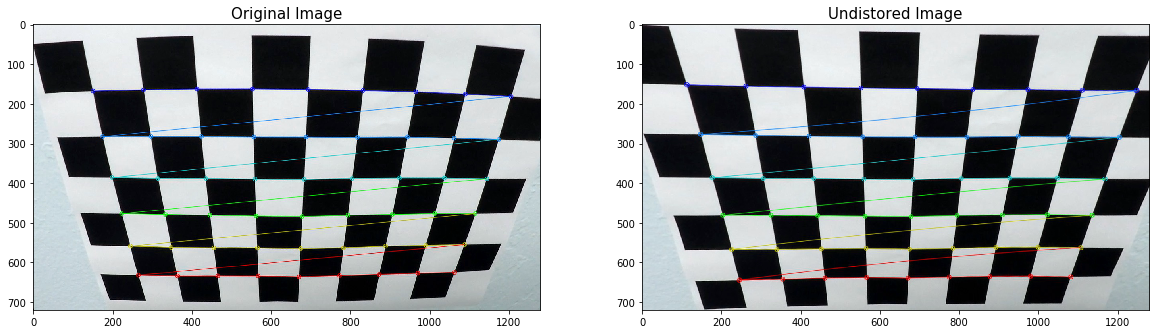

In [174]:
def test():
    """
    read the pickle file on disk and implement undistor on image
    show the oringal/undistort image
    """
    print("Reading the camera calibration parameters...")
    pickle_file = open("./camera_cal/camera_cal.p", "rb")
    dist_pickle = pickle.load(pickle_file)
    mtx = dist_pickle["mtx"]  
    dist = dist_pickle["dist"]
    pickle_file.close()

    print("Reading the sample image...")
    img = cv2.imread('./camera_cal/corners_found/calibration2.jpg')
    img_size = (img.shape[1],img.shape[0])
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Visualize undistortion
    print("Visulize the result...")
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.imshow(img), ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(dst), ax2.set_title('Undistored Image', fontsize=15)
    plt.show()

test()

## Helper functions that build up a pipeline

In [175]:
def get_camera_cal():
    """
    Read the picke file and return the mtx, dist to caller
    """
    pickle_file = open("./camera_cal/camera_cal.p", "rb")
    dist_pickle = pickle.load(pickle_file)
    mtx = dist_pickle["mtx"]  
    dist = dist_pickle["dist"]
    pickle_file.close()
    
    return mtx, dist

def undistort_image(img, mtx, dist):
    """
    Undistort an image, before calling this function, the camera calibration parameters
    should already be obtained by calling get_camera_cal()
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

def color_gradient_thresh(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    This is a combination of color and gradient thresholds to generate a binary image.
    In color space: it usees the s channel in HLS space;
    for gradient, it usees x direction gradient. 
    """
    np_img = np.copy(img)
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(np_img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivateive in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivateive to accentuate lines
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # combine the two binary
    binary = sxbinary | s_binary

    # Stack each channel (for visual check the pixal sourse)
    # color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary,s_binary)) * 255
    return binary

def yellow_filter(image, low=(10,50,0), high=(30,255,255)):
    """
    filter the right side yellow line out
    """
    image_HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image_filtered = cv2.inRange(image_HSV, low, high)

    return image_filtered

def white_filter(image, low=(0,0,0), high=(255,255,255)):
    """
    """
    image_filtered = cv2.inRange(image, low, high)

    return image_filtered

def yellow_white_thresh(img, y_low=(10,50,0), y_high=(30,255,255), w_low=(180,180,180), w_high=(255,255,255)):
    
    yellow_filtered = yellow_filter(img, y_low, y_high)
    yellow_filtered[yellow_filtered > 0] = 1 # transfer to binary

    white_filtered = white_filter(img, w_low, w_high) # transfer to binary
    white_filtered[white_filtered > 0] = 1

    # combine the two binary, right and left
    yellow_filtered[:,640:] = 0 # use left side of yellow filtered
    white_filtered[:, :640] = 0 # use the right side of white filtered

    binary = yellow_filtered | white_filtered

    return binary

def yellow_white_auto_gradient_thresh(img, y_low=(10,0,0), y_high=(30,255,255), w_low=(180,180,180), w_high=(255,255,255)):
    """
    auto adjust the y_low(_,_,*), V channel value according the image brightness
    auto adjust the w_low(*,*,*) according the image brightness
    """
    height = img.shape[0]
    width = img.shape[1]
    y_offset = 0    # the yellow offset add to mean brightness
    w_offset = 30   # the white offset add to mean brightness
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    V = HSV[:,:,2]
    bright_lb = int(np.mean(V[height//2:, :width//2]))  # use left bottom corner brightness as ref
    bright_rb = int(np.mean(V[height//2:, width//2:]))  # use right bottom corner brightness as ref

    y_low = (10, 0, bright_lb+y_offset) # set the yellow V low according the brightness
    
    w_low_thresh = min(bright_rb+w_offset, 255-10) # solve the problem that the valve > 255
    w_low = (w_low_thresh, w_low_thresh, w_low_thresh)  # set the white low valuse according the brightness

    sx_thresh=(30, 120)
    if bright_rb > 120:
        sx_thresh = (bright_rb - 80, bright_rb)
    sobelx = cv2.Sobel(V, cv2.CV_64F, 1, 0) # Take the derivateive in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivateive to accentuate lines
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    yellow_filtered = yellow_filter(img, y_low, y_high)
    yellow_filtered[yellow_filtered > 0] = 1 # transfer to binary

    white_filtered = white_filter(img, w_low, w_high) # transfer to binary
    white_filtered[white_filtered > 0] = 1

    # combine the two binary, right and left
    yellow_filtered[:,640:] = 0 # use left side of yellow filtered
    white_filtered[:, :640] = 0 # use the right side of white filtered
    sxbinary[:,:640] = 0
    
    binary = yellow_filtered | white_filtered | sxbinary
    #binary = yellow_filtered | sxbinary

    # apply edge finding to avoid block white area.
    binary = cv2.Laplacian(binary,cv2.CV_64F) # use floating piont to get postive and negetive gradient
    binary = np.absolute(binary) # transfer to abs value
    binary = np.uint8(binary) # transfer to uint8
    binary[binary > 0] = 1 # transfer to binary again

    return binary

def test_thresh(image, ksize = 11, mask_half=False):
    
    hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
    gray = (0.5*image[:,:,0] + 0.4*image[:,:,1] + 0.1*image[:,:,2]).astype(np.uint8)
    s = hls[:,:,2]
    
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

    total_px = image.shape[0]*image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
    if cv2.countNonZero(mask_three)/total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask_two = s_binary

    binary = np.clip(cv2.bitwise_and(gray_binary, cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')

    # Mask out top half of image to reduce distractions
    # Only used when unwarped image is passed in
    if mask_half:
        print(ceil(image.shape[0]//2))
        binary[:ceil(image.shape[0]//2)] = 0

    return binary

def get_perspective_transform_params():
    """
    Read the picke file and return the M, Minv to caller
    """
    pickle_file = open("trans_pickle.p", "rb")
    dist_pickle = pickle.load(pickle_file)
    M = dist_pickle["M"]  
    Minv = dist_pickle["Minv"]
    pickle_file.close()
    
    return M, Minv

def perspective_transform(image, M):
    """
    Do a perspective transform for an image, before calling this function, the transform parameters
    should already be obtained by calling get_perspective_transform_params()
    """
    img_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

def find_lane_sliding_window(warped_thresholed_img):
    """
    find lane in a warped and thresholed binary image
    input: warped_thresholed_img image
    output: left/right lane pixel poistion and a drawed search image
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_thresholed_img[warped_thresholed_img.shape[0]//2:,:], axis=0)

    # plt.plot(histogram)
    # plt.show()

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_thresholed_img, warped_thresholed_img, warped_thresholed_img))*255

    # Find the peak of the left and right havleve of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2) # 1280/2=640
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nWindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimu number of pixels found to recenter window
    min_pix = 50
    # Set height of windows - based on nWindows above adn image shape
    window_height = np.int(warped_thresholed_img.shape[0]//nWindows)
    # Identify the x and y positions of all nonzero(i.e. activated) pixels in the image
    nonzero = warped_thresholed_img.nonzero()
    nonzeroy = np.array(nonzero[0]) # y is row, x is col
    nonzerox = np.array(nonzero[1])
    # Current postions to be updated later for each window in n_window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nWindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_thresholed_img.shape[0] - (window+1)*window_height
        win_y_high = warped_thresholed_img.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visulization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high), (0,255,0),2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
            (win_xright_high, win_y_high), (0,255,0),2)
        
        # plt.imshow(out_img)
        # plt.show()

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]    # nonzero() return a tuple, get the list for tuple
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]  # nonzero() return a tuple, get the list for tuple

        # Append these indices to hte lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # # update the window center for next round window scan
        if len(good_left_inds) > min_pix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of list)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty, rightx, righty, out_img)

def find_lane_sliding_window_adjusted(binary_warped):
    """
    find lane in a warped and thresholed binary image
    input: warped_thresholed_img image
    output: left/right lane pixel poistion and a drawed search image
    compared to find_lane_sliding_window, added
        1. search window side check, stop search when reaches side
        2. search window start piostion check
        3. noise window discard, discard when too many hits.
        4. blank window distcard, if the window is blank, stop search.
        5. adjusted window size, change the window size(when the lane is curved much, 
            the window counln't shift quickly, plan to change the window height half and just search half of the image. )
    """
    img_height = binary_warped.shape[0]
    img_width = binary_warped.shape[1]


    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[img_height//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right havleve of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2) # 1280/2=640
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # check if the left_base/right base is in range
    leftx_base_range = range(img_width//4-100, img_width//4+200)    # the right limit + 100 ()
    rightx_base_range = range(img_width//4*3-100, img_width//4+200)
    
    if (leftx_base in leftx_base_range) and (rightx_base in rightx_base_range): # good condistion
        pass
    elif ((leftx_base in leftx_base_range) == False) and ((rightx_base in rightx_base_range) == True):
        leftx_base = rightx_base + img_width//2
    elif ((leftx_base in leftx_base_range) == True) and ((rightx_base in rightx_base_range) == False):
         rightx_base = leftx_base + img_width//2
    else: # if left and right start piont all not in range, set to a predecided point
        leftx_base = img_width//4
        rightx_base = img_width//4*3


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nWindows = 18   # version 1 is 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimu number of pixels found to recenter window
    min_pix = 50 # 50 
    # Set height of windows - based on nWindows above adn image shape
    window_height = np.int(binary_warped.shape[0]//nWindows)
    # Identify the x and y positions of all nonzero(i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0]) # y is row, x is col
    nonzerox = np.array(nonzero[1])
    # Current postions to be updated later for each window in n_window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # flag's
    l_stop = False  # if this flag is true, skip the search
    r_stop = False

    l_blank = False # if the search result of this window is blank and the flag is True, set the stop flag true
    r_blank = False

    for window in range(nWindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # check the window postion
        if win_xleft_low < 0 or win_xleft_high > img_width//2:
            l_stop = True
            r_stop = True # when one side hit border, stop two side search
        if win_xright_low < img_width//2 or win_xright_high > img_width:
            r_stop = True
            l_stop = True # when one side hit border, stop two side search
        
        # plt.imshow(out_img)
        # plt.show()

        # check the stop flag the dothe search
        if not l_stop:
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]    # nonzero() return a tuple, get the list for tuple
            # Draw the windows on the visulization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                            (win_xleft_high, win_y_high), (0,255,0),2)
        if not r_stop: 
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]  # nonzero() return a tuple, get the list for tuple
            # Draw the windows on the visulization image
            cv2.rectangle(out_img, (win_xright_low, win_y_low),
                            (win_xright_high, win_y_high), (0,255,0),2)
        
        # adjust this according thresh method, left 0.99, use color select, right use edagdetection
        noise_thresh_left = int(window_height*(margin+margin)*0.99) 
        noise_thresh_right = int(window_height*(margin+margin)*0.5)
        # # update the window center for next round window scan and searched list, only the pionts number meet the range, else is not searched, window is blank
        if (len(good_left_inds) > min_pix) and (len(good_left_inds) < noise_thresh_left):
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
            left_lane_inds.append(good_left_inds)
        else:   # when there is no siganl < 50 or 30% window is ocupied, noise, consider this window is blank
            if l_blank == True: # secong blank window, stop search
                l_stop = True
            else:
                l_blank = True # firstime, set l_blank to True
        
        if (len(good_right_inds) > min_pix) and (len(good_right_inds) < noise_thresh_right):
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            right_lane_inds.append(good_right_inds)
        else:
            if r_blank == True: # second time blank window, stop search
                r_stop = True
            else:
                r_blank = True  # firstime, set r_blank flag to True

    # Concatenate the arrays of indices (previously was a list of list)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    try:
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty, rightx, righty, out_img)

def calculate_curvature(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700, Y_MAX=720, X_MAX=1280):
    '''
    Calcualtes the curvature of polynomial functions in meters
    '''
    # Transform pixel to meters
    leftx = leftx * xm_per_pix
    lefty = lefty * ym_per_pix
    rightx = rightx * xm_per_pix
    righty = righty * ym_per_pix

    # fit the polynomial
    left_fit_cr = np.polyfit(lefty, leftx, 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)

    # Define y-value where we want radius of curvature
    # choose the maximum y-value
    y_eval = Y_MAX * ym_per_pix

    # Implement the caculation of R_curve
    # Caluate the radius R = (1+(2Ay+B)^2)^3/2 / (|2A|)
    radius_fun = lambda A, B, y: (1+(2*A*y+B)**2)**(3/2) / abs(2*A)

    left_curverad = radius_fun(left_fit_cr[0], left_fit_cr[1], y_eval)
    right_curverad = radius_fun(right_fit_cr[0], right_fit_cr[1], y_eval)

    return left_curverad, right_curverad

def calculate_offset(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700, Y_MAX=720, X_MAX=1280):
    '''
    calculate the the offest from lane center
    '''
    # HYPOTHESIS : the camera is mounted at the center of the car
    # the offset of the lane center from the center of the image is 
    # distance from the center of lane
    
    # Transform pixel to meters
    leftx = leftx * xm_per_pix
    lefty = lefty * ym_per_pix
    rightx = rightx * xm_per_pix
    righty = righty * ym_per_pix

    # fit the polynomial
    left_fit_cr = np.polyfit(lefty, leftx, 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)

    # Define y-value where we want radius of curvature
    # choose the maximum y-value
    y_eval = Y_MAX * ym_per_pix

    left_point = np.poly1d(left_fit_cr)(y_eval)
    right_point = np.poly1d(right_fit_cr)(y_eval)

    lane_center = (left_point + right_point) / 2
    image_center = X_MAX * xm_per_pix / 2

    offset = lane_center - image_center

    return offset

def get_polynomial(leftx, lefty, rightx, righty, img_size):


    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_lane_fun = np.poly1d(left_fit)
    right_lane_fun = np.poly1d(right_fit)

    ploty = ploty = np.linspace(0, img_size[0]-1, img_size[0])
    left_fitx = left_lane_fun(ploty)
    right_fitx = right_lane_fun(ploty)

    return left_fitx, right_fitx, ploty

def draw_lane(undist, warped, Minv, leftx, lefty, rightx, righty):
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0 ,0 , 255]

    new_warp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))

    result = cv2.addWeighted(undist, 1, new_warp, 0.3, 0)

    return result

def draw_lane_fit(undist, warped, Minv, left_fitx, right_fitx, ploty):
    # Drawing
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix(Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, new_warp, 0.3, 0)

    return result

def draw_lane_info(image, radius, offset, color=(100,255,100)):
    """
    project the fited lane information to the image
    use last 15 frame average data to avoid the number quick jump on screen.
    """
    if offset < 0:
        direction = "right"
    else:
        direction = "left"
    str_radius = "Radius of Curvature = {}m".format(int(radius))
    str_offset = "Vehicle is {0:.2f}m ".format(abs(offset)) + "{} of center".format(direction)
    cv2.putText(image, str_radius, (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    cv2.putText(image, str_offset, (50,120), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)

## Apply undistortion on a raw image captured by the same camera

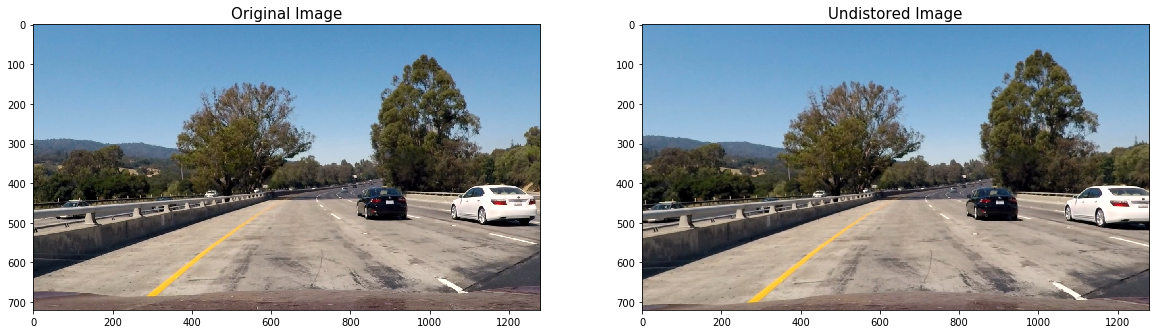

True

In [176]:
mtx, dist = get_camera_cal()
img = cv2.imread('test_images/test1.jpg')
# OpenCV loads in BGR by default
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = undistort_image(rgb_img, mtx, dist)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(rgb_img), ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted), ax2.set_title('Undistored Image', fontsize=15)
plt.show()

# save to output_images
bgr_undistorted = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR)
cv2.imwrite(os.path.join("./output_images/test1_undistored.jpg", ), bgr_undistorted)


## Threshold an image

### Use color transforms and gradients to threshold an image

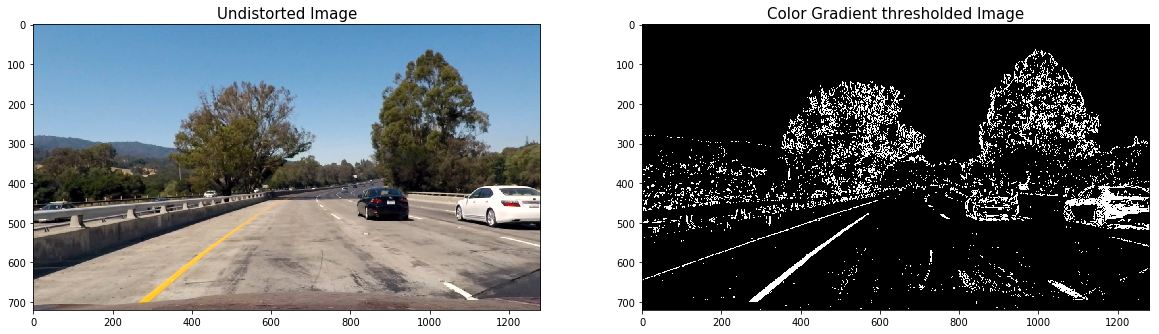

True

In [177]:
thresholded_img = color_gradient_thresh(undistorted)

# save to output_images
thresholded_img_visual = cv2.cvtColor(thresholded_img*255, cv2.COLOR_GRAY2RGB)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistorted), ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(thresholded_img_visual), ax2.set_title('Color Gradient thresholded Image', fontsize=15)
plt.show()

# save to output_images
cv2.imwrite("./output_images/test1_color_gradient_thresholded.jpg", thresholded_img_visual)

### Use only yellow and white to threshold an image

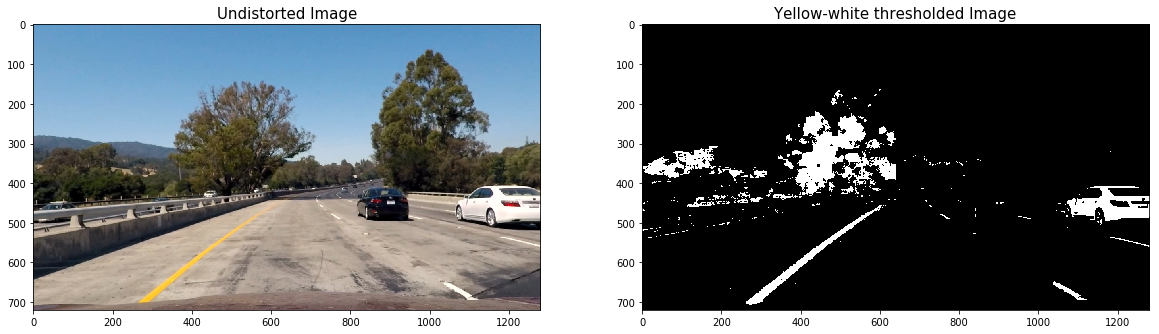

True

In [178]:
y_low=(15,65,0)
y_high=(25,255,255)
w_low=(200,200,200)
w_high=(255,255,255)

yellow_white_thresholded = yellow_white_thresh(undistorted, y_low, y_high, w_low, w_high)
yellow_white_thresholded_visual = cv2.cvtColor(yellow_white_thresholded*255, cv2.COLOR_GRAY2RGB)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistorted), ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(yellow_white_thresholded_visual), ax2.set_title('Yellow-white thresholded Image', fontsize=15)
plt.show()

# save to output_images
cv2.imwrite("./output_images/test1_yellow_white_thresholded.jpg", yellow_white_thresholded_visual)

### Use dynamic yellow and white and gradient to threshold an image

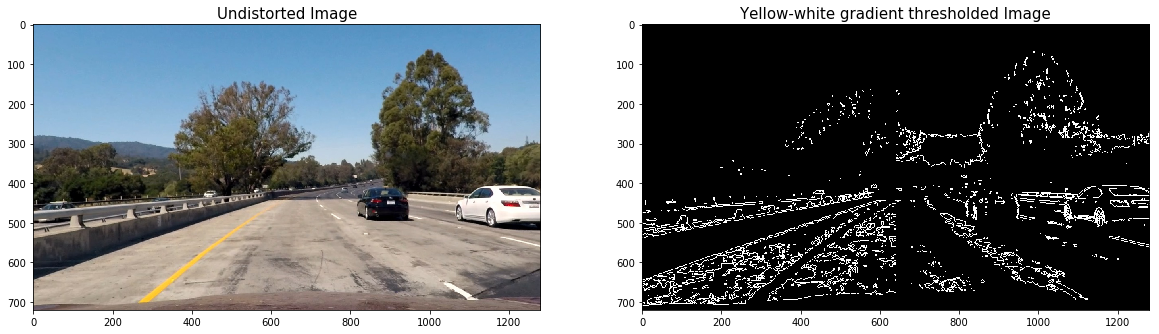

True

In [179]:
y_low=(15,65,0)
y_high=(30,45,255)
w_low=(200,200,200)
w_high=(255,255,255)

yellow_white_gradient_thresholded = yellow_white_auto_gradient_thresh(undistorted, y_low, y_high, w_low, w_high)
yellow_white_gradient_thresholded_visual = cv2.cvtColor(yellow_white_gradient_thresholded*255, cv2.COLOR_GRAY2RGB)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistorted), ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(yellow_white_gradient_thresholded_visual), ax2.set_title('Yellow-white gradient thresholded Image', fontsize=15)
plt.show()

# save to output_images
cv2.imwrite("./output_images/test1_yellow_white_gradient_thresholded.jpg", yellow_white_gradient_thresholded_visual)

## Perspective transform
We need to get a transform parameter M and the inverse transform parameter Minv. I did this once and save these two parameters to a pickle file just like how I get camera_cal.p. I had to pick 4 source points, which I did manually.

Draw lines on image for better visualisation...
Saving the perspective transform parameters to file: trans_pickle.p
Visulize the perspective trasnform result...


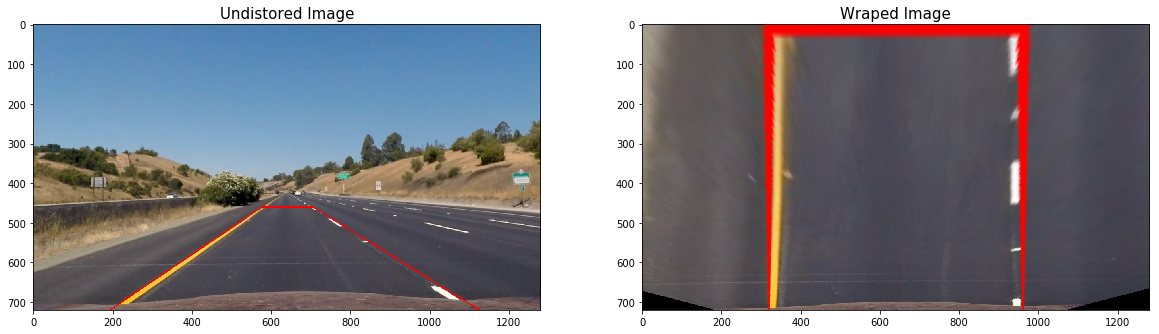

True

In [180]:
def calculate_perspective_transform(image):
    """
    This functions gets an undistorted image, and get its bird-eye view.
    It also saves the transform parameters in to a pickle file. Note this only works for specific
    test sets. In this example here, it works for test_images/straight_lines1.jpg
    """
    img_size = (image.shape[1], image.shape[0])
    
    # copied from Udacity lecture and modified manully
    src = np.float32(
        [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    # draw 4 lines
    print("Draw lines on image for better visualisation...")
    cv2.line(image, tuple(src[0]), tuple(src[1]), [255,0,0], 2)
    cv2.line(image, tuple(src[1]), tuple(src[2]), [255,0,0], 2)
    cv2.line(image, tuple(src[2]), tuple(src[3]), [255,0,0], 2)
    cv2.line(image, tuple(src[3]), tuple(src[0]), [255,0,0], 2)

    cv2.line(warped, tuple(dst[0]), tuple(dst[1]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[1]), tuple(dst[2]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[2]), tuple(dst[3]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[3]), tuple(dst[0]), [255,0,0], 2)

    # write to pickle file
    print("Saving the perspective transform parameters to file: trans_pickle.p")
    trans_pickle = {}
    trans_pickle["M"] = M
    trans_pickle["Minv"] = Minv 
    pickle_file = open("./trans_pickle.p", "wb")
    pickle.dump(trans_pickle, pickle_file)
    pickle_file.close()


straight_img = cv2.imread('test_images/straight_lines1.jpg')
# OpenCV loads in BGR by default
rgb_straight_img = cv2.cvtColor(straight_img, cv2.COLOR_BGR2RGB)
undistorted_rgb_straight_img = undistort_image(rgb_straight_img, mtx, dist)
calculate_perspective_transform(undistorted_rgb_straight_img)

M, Minv = get_perspective_transform_params()
warped = perspective_transform(undistorted_rgb_straight_img, M)

print("Visulize the perspective trasnform result...")
f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistorted_rgb_straight_img), ax1.set_title('Undistored Image', fontsize=15)
ax2.imshow(warped), ax2.set_title('Wraped Image', fontsize=15)
plt.show()

# save to output_images
to_save = cv2.cvtColor(undistorted_rgb_straight_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/straight_lines1_trapezoid.jpg", to_save)
to_save = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/straight_lines1_warped.jpg", to_save)

## Find lane pixels

True

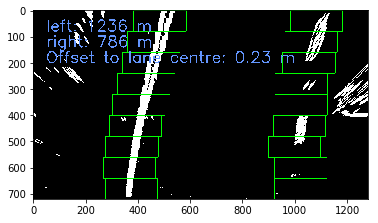

In [181]:
test_img = cv2.imread('test_images/test6.jpg')
# OpenCV loads in BGR by default
rgb_test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undistorted_rgb_test_img = undistort_image(rgb_test_img, mtx, dist)
undistorted_thresholed_rgb = color_gradient_thresh(undistorted_rgb_test_img)

warped = perspective_transform(undistorted_thresholed_rgb, M)
img_size = (warped.shape[1], warped.shape[0])
leftx, lefty, rightx, righty, out_warped_img = find_lane_sliding_window(warped)

left_curverad, right_curverad = calculate_curvature(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700)
offset = calculate_offset(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700)

cur_left = "left: {} m".format(int(left_curverad))
cur_right = "right: {} m".format(int(right_curverad))
cur_pos = "Offset to lane centre: {:.2f} m".format(float(offset))

cv2.putText(out_warped_img,cur_left, (50,80), cv2.FONT_HERSHEY_SIMPLEX,2,(100,150,255),3)
cv2.putText(out_warped_img,cur_right, (50,140), cv2.FONT_HERSHEY_SIMPLEX,2,(100,150,255),3)
cv2.putText(out_warped_img,cur_pos, (50,200), cv2.FONT_HERSHEY_SIMPLEX,2,(100,150,255),3)
    
plt.imshow(out_warped_img)

# save to output_images
to_save = cv2.cvtColor(out_warped_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/test6_lane_detected.jpg", to_save)

## Draw lane area and display the curvature and offset text

### Draw polynomial fitted lanes

True

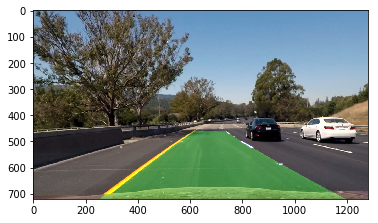

In [182]:
result = draw_lane(undistorted_rgb_test_img, warped, Minv, leftx, lefty, rightx, righty)
# get the polynomial line points
left_fitx, right_fitx, ploty = get_polynomial(leftx, lefty, rightx, righty, img_size)
result = draw_lane_fit(result, warped, Minv, left_fitx, right_fitx, ploty)
plt.imshow(result)

# save to output_images
to_save = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/test6_lane_painted.jpg", to_save)

### Display curvature and offset information

True

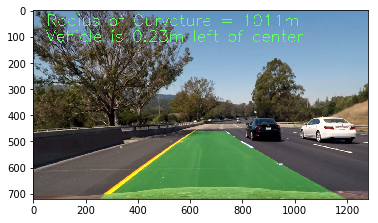

In [183]:
draw_lane_info(result, (left_curverad + right_curverad)/2, offset, color=(100,255,100))

plt.imshow(result)

# save to output_images
to_save = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/test6_lane_info_displayed.jpg", to_save)

## Create a pipeline class that constructs left and right lines

In [184]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = [] 
        #distance in meters of vehicle center from the line
        self.line_base_pos = [] 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []

def fit_polynomial(leftx, lefty, rightx, righty, out_img):
    """
    fit left and right lane polynomi
    """
    # check if there is search failure
    if leftx.size == 0 or lefty.size == 0:
        cv2.putText(out_img,"Search failure", (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,255),3)
        return out_img 

    # line fit use np.ployfit, second order, note lefty is x, leftx is y, later use ploty to get plotx
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # print(left_fit)
    # print(right_fit)

    left_lane_fun = np.poly1d(left_fit)
    right_lane_fun = np.poly1d(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
    left_plotx = left_lane_fun(ploty)
    right_plotx = right_lane_fun(ploty)

    # Visualization
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0 ,0 , 255]

    # draw fit line(sue 9 stright line)
    for i in range(0, 9):
        cv2.line(out_img, (int(left_plotx[i*79]), int(ploty[i*79])), (int(left_plotx[(i+1)*79]), int(ploty[(i+1)*79])), (255,255,0),2)
        cv2.line(out_img, (int(right_plotx[i*79]), int(ploty[i*79])), (int(right_plotx[(i+1)*79]), int(ploty[(i+1)*79])), (255,255,0),2)        
    
    return out_img
    
class Pipeline():
    '''
    pipeline class with has left/right line class to hold the related information
    '''
    # Get cal and tranform parameter, set as class variable
    print("Import the camera calbration parameter & view_perspective tranform parameter...")
    mtx, dist = get_camera_cal()
    M, Minv = get_perspective_transform_params()

    def __init__(self, left, right):
        '''
        initial with left, right line class
        '''
        self.left = left    # the Line() class to keep the left line info
        self.right = right  # the Line() class to keep the left line info
        self.image_counter = 0      # the image counter
        self.fit_fail_counter = 0   # this is used record the fit lane not meet the requirement
        self.fit_ok = False     # flag use to record fit lane is ok or not
        self.search_fail_counter = 0 # this is used to record lane pixel search failure.
        self.search_ok = False  # flag use to record lane search is ok or not
        self.smooth_number = 23 # use to average the radius valude to let the screen number not so jump
        self.show_debug_window = False # Option if turn on the debug window in the pipeline
        self.radius = [] # store the radius data, arverage of left/right lane cur
        self.offset = [] # store the car center offset from lane center
        self.quick_search = False # not implement, use last time fit line to quick search the lane points
        self.search_method = 1 # not implement 1/slid window, 2/convelustional, 
    
    def project_debug_window(self, image_warped, left_curverad, right_curverad, lane_check_result, search_result):
        """
        return a 360*640 debug window
        """
        # unpack the parameters
        leftx, lefty, rightx, righty, out_img = search_result
        detected, lane_distance_bot, lane_distance_mid, lane_distance_top = lane_check_result
                
        # check if search is OK
        if self.search_ok:      
            # the right-up corner window for debug.
            leftx, lefty, rightx, righty, out_img = search_result
            fit_image = fit_polynomial(leftx, lefty, rightx, righty, out_img)
            
            # santiy check window           
            cur_left = "left: {}".format(int(left_curverad))
            cur_right = "right: {}".format(int(right_curverad))
            info_str = "{}, {}, {}, {}".format(detected, int(lane_distance_bot), int(lane_distance_mid), int(lane_distance_top))

            cv2.putText(fit_image,cur_left, (50,580), cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,255),3)
            cv2.putText(fit_image,cur_right, (50,640), cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,255),3)
            cv2.putText(fit_image,info_str, (50,700), cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,255),3)
            
            # set the debug window size
            fit_image_resize = cv2.resize(fit_image, (640, 360))

            return fit_image_resize

        else:   # if search failure, just put "search fail" text on img and return the img
            cv2.putText(out_img,'Lane find fail', (50,50), cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,0),3)
            out_img_resize = cv2.resize(out_img, (640, 360))
            return out_img_resize

    def lane_manual_check(self, left_fitx, right_fitx, ploty):
        '''
        Check that if left and right have similar curvature margin
        '''
        flag = True
        lane_distance_bot = right_fitx[720] - left_fitx[720]
        lane_distance_mid = right_fitx[320] - left_fitx[320]
        lane_distance_top = right_fitx[0] - left_fitx[0]

        # tranform calibration distence 1280/2 is 640, 5%(610-670) is good search, 15%(545-730) is detected
        if ((lane_distance_bot < 545) or (lane_distance_bot > 730)): flag = False
        if ((lane_distance_mid < 545) or (lane_distance_mid > 730)): flag = False
        if ((lane_distance_top < 500) or (lane_distance_top > 730)): flag = False # change top to 500, in some frame, the road in not flat, the lane will be small far from camera

        return flag, lane_distance_bot, lane_distance_mid, lane_distance_top

    
    def lane_manual_check_color(self, left_fitx, right_fitx, ploty):
        '''
        Check that if left and right have similar curvature margin
        '''
        flag = True
        lane_distance_bot = right_fitx[720] - left_fitx[720]
        lane_distance_mid = right_fitx[320] - left_fitx[320]
        lane_distance_top = right_fitx[0] - left_fitx[0]

        if ((lane_distance_bot < 480) or (lane_distance_bot > 600)): flag = False
        if ((lane_distance_mid < 350) or (lane_distance_mid > 500)): flag = False
        if ((lane_distance_top < 150) or (lane_distance_top > 500)): flag = False

        return flag, lane_distance_bot, lane_distance_mid, lane_distance_top

    def lane_manual_check_shadow(self, left_fitx, right_fitx, ploty):
        '''
        Check that if left and right have similar curvature margin
        '''
        flag = True
        lane_distance_bot = right_fitx[720] - left_fitx[720]
        lane_distance_mid = right_fitx[320] - left_fitx[320]
        lane_distance_top = right_fitx[0] - left_fitx[0]

        if ((lane_distance_bot < 400) or (lane_distance_bot > 700)): flag = False
        if ((lane_distance_mid < 400) or (lane_distance_mid > 1200)): flag = False
        if ((lane_distance_top < 200) or (lane_distance_top > 2200)): flag = False

        return (flag, lane_distance_bot, lane_distance_mid, lane_distance_top)

    def store_search(self, leftx, lefty, rightx, righty):
        """
        update the search result
        """
        self.left.allx.append(leftx)
        self.left.ally.append(lefty)
        self.right.allx.append(rightx)
        self.right.ally.append(righty)

    def get_recent_search(self):
        """
        output recent search result
        """
        leftx = self.left.allx[-1]
        lefty = self.left.ally[-1]
        rightx = self.right.allx[-1]
        righty = self.right.ally[-1]

        return leftx, lefty, rightx, righty

    def store_fit(self, left_fitx, right_fitx):

        self.left.recent_xfitted.append(left_fitx)
        self.right.recent_xfitted.append(right_fitx)

    def get_recent_fit(self):
        left_fitx = self.left.recent_xfitted[-1]
        right_fitx = self.right.recent_xfitted[-1]

        return left_fitx, right_fitx

    def draw_lane_info(self, image, color=(100,255,100)):
        """
        project the fited lane information to the image
        use last 15 frame average data to avoid the number quick jump on screen.
        """
        offset = np.mean(self.offset[-self.smooth_number:-1]) if len(self.offset) > self.smooth_number else np.mean(self.offset)
        curverad = np.mean(self.radius[-self.smooth_number:-1]) if len(self.radius) > self.smooth_number else np.mean(self.radius)
        direction = "right" if offset < 0 else "left"
        str_cur = "Radius of Curvature = {}(m)".format(int(curverad))
        str_offset = "Vehicle is {0:.2f}m ".format(abs(offset)) + "{} of center".format(direction)
        cv2.putText(image, str_cur, (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
        cv2.putText(image, str_offset, (50,120), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    
    def pipeline_basic(self, image):
        return self.pipeline(image, method="basic")
    
    def pipeline_color(self, image):
        return self.pipeline(image, method="color")
    
    def pipeline_shadow(self, image):
        return self.pipeline(image, method="shadow")
    
    def pipeline(self, image, method="basic"):
        # counter the image
        self.image_counter += 1
        
        img_size = (image.shape[1], image.shape[0])

        # undistort the image
        image_undist = undistort_image(image, Pipeline.mtx, Pipeline.dist)

        # apply thresholding
        if method == "basic":
            s_thresh=(170,255)
            sx_thresh=(20, 100)
            image_threshed = color_gradient_thresh(image_undist, s_thresh=s_thresh, sx_thresh=sx_thresh)
        elif method == "color":
            y_low=(10,50,0)
            y_high=(30,255,255)
            w_low = (200,200,200)
            w_high=(255,255,255)
            image_threshed = yellow_white_thresh(image_undist, y_low, y_high, w_low, w_high)
        elif method == "shadow":
            #y_low=(10,0,0)
            #y_high=(30,200,255)
            #w_low = (180,180,180)
            #w_high=(255,255,255)
            y_low=(15,65,0)
            y_high=(25,255,255)
            w_low=(200,200,200)
            w_high=(255,255,255)
            image_threshed = yellow_white_auto_gradient_thresh(image_undist, y_low, y_high, w_low, w_high)
            
        # apply the view_perspective tranform
        image_warped = cv2.warpPerspective(image_threshed, Pipeline.M, img_size, flags=cv2.INTER_LINEAR)
        
        # find lane pixels
        if method == "basic" or method == "color":
            search_result = find_lane_sliding_window(image_warped)
        elif method == "shadow":
            search_result = find_lane_sliding_window_adjusted(image_warped)
        leftx, lefty, rightx, righty, out_img = search_result

        # check the pixels search result, if the leftx or lefty is empyt, use recent data, if there is no recent data, return the image it self
        if leftx.size == 0 or rightx.size == 0:
            self.search_ok = False
            self.search_fail_counter += 1
            
            if self.left.allx == []:
                return image # logical choise, only happend first frame search failed, or first n frame search failed
            else:   # use recent search result
                leftx, lefty, rightx, righty = self.get_recent_search()
        else: # store the search result
            self.search_ok = True
            self.store_search(leftx, lefty, rightx, righty)

        # get the polynomial line points
        left_fitx, right_fitx, ploty = get_polynomial(leftx, lefty, rightx, righty, img_size)

        if method == "basic":
            lane_check_result = self.lane_manual_check(left_fitx, right_fitx, ploty)
        elif method == "color":
            lane_check_result = self.lane_manual_check_color(left_fitx, right_fitx, ploty)
        elif method == "shadow":
            lane_check_result = self.lane_manual_check_shadow(left_fitx, right_fitx, ploty)

        self.fit_ok, lane_distance_bot, lane_distance_mid, lane_distance_top = lane_check_result

        if self.fit_ok:
            # store the fit result
            self.store_fit(left_fitx, right_fitx)
        # if there is no good fit, just skip and use the bad fit
        elif self.left.recent_xfitted == []:
            self.fit_fail_counter += 1
        # if there is at least a good fit, use the most recent fit
        else:   # use previous data
            self.fit_fail_counter += 1
            # use the recent_xfitted
            left_fitx, right_fitx = self.get_recent_fit()
            # use the recent pionts
            leftx, lefty, rightx, righty = self.get_recent_search()

        # measure the curverad and offset
        left_curverad, right_curverad = calculate_curvature(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700)
        curverad = (left_curverad + right_curverad) / 2
        offset = calculate_offset(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700)

        # store the lane data for furthre caculation
        self.radius.append(curverad)
        self.offset.append(offset)

        # draw the lane to the undist image
        if self.fit_ok: # 
            result = draw_lane(image_undist, image_warped, Pipeline.Minv, leftx, lefty, rightx, righty)
            result = draw_lane_fit(result, image_warped, Pipeline.Minv, left_fitx, right_fitx, ploty)
        else:   # if the fit not OK, just draw the last fit line
            result = draw_lane_fit(image_undist, image_warped, Pipeline.Minv, left_fitx, right_fitx, ploty)

        # write curverad and offset on to result image
        self.draw_lane_info(result)

        if self.show_debug_window:
            debug_window = self.project_debug_window(image_warped, left_curverad, right_curverad, lane_check_result, search_result)
            result[:360,640:]=debug_window

            # write the fit_failure image for ananlysis
            if (not self.fit_ok) or (not self.search_ok):
                fileName = "output_video/debug/fail_frames/"+str(self.image_counter)+".jpg"
                write_img = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
                cv2.imwrite(fileName, write_img)
    
        return result

Import the camera calbration parameter & view_perspective tranform parameter...


### A test functions that uses Pipeline class to process jpg images under a specific folder

In [185]:
def process_images_test(src_folder, dst_folder):
    # create pipeline instance
    left = Line()
    right = Line()
    pipeline = Pipeline(left, right)
    
    image_files = glob.glob(src_folder + "*.jpg")
    for idx, file in enumerate(image_files):
        print("handle on: ", file)
        img = mpimg.imread(file)
        
        result = pipeline.pipeline(img)  
        
        file_name = file.split("/")[-1]
        out_image = dst_folder + "processed_" + file_name
        image_dist = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite(out_image, image_dist)
        
    print("Processed", pipeline.image_counter, "images")
    print("Fit Failure: ", pipeline.fit_fail_counter)
    print("Find lane Failure: ", pipeline.search_fail_counter)
    print("Wrote the processed image to: ", dst_folder)

process_images_test("test_images/", "output_images/")

handle on:  test_images/test6.jpg
handle on:  test_images/test5.jpg
handle on:  test_images/test4.jpg
handle on:  test_images/test1.jpg
handle on:  test_images/test3.jpg
handle on:  test_images/test2.jpg
handle on:  test_images/straight_lines2.jpg
handle on:  test_images/straight_lines1.jpg
Processed 8 images
Fit Failure:  1
Find lane Failure:  0
Wrote the processed image to:  output_images/


### Apply to videos

In [186]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(video, subclip=False, method="basic", show_debug_info=False):
    '''
    handle a video using pipeline function
    '''
    # Create pipeline instance
    print("Initialising Pipeline ...")
    left = Line()
    right = Line()
    pipeline = Pipeline(left, right)
    if show_debug_info:
        pipeline.show_debug_window = True

    # check if handle the subclip
    if subclip:
        print("Will just process first 5 seconds of the video")
        clip = VideoFileClip(video).subclip(0,5)
    else:
        print("Will process the whole video")
        clip = VideoFileClip(video)
    
    # choice the pipeline according the video
    if method == "basic":
        output_clip = clip.fl_image(pipeline.pipeline_basic)
    elif method == "color":
        output_clip = clip.fl_image(pipeline.pipeline_color)
    elif method == "shadow":
        output_clip = clip.fl_image(pipeline.pipeline_shadow)

    if show_debug_info:
        output_file = "output_video/debug/" + video
    else:
        output_file = "output_video/" + video
    output_clip.write_videofile(output_file, audio=False)

    # write the information to the consel
    print("Processed {} images".format(pipeline.image_counter))
    print("Detected Failure: {}".format(pipeline.fit_fail_counter))
    print("Find Lane Failure: {}".format(pipeline.search_fail_counter))
    print("The video is at ./output_video/")
    
    # write the information to log file
    with open("./output_video/debug/log.txt", "w") as text_file:
        print("Processed {} images".format(pipeline.image_counter), file=text_file)
        print("Detected Failure: {}".format(pipeline.fit_fail_counter), file=text_file)
        print("Find Lane Failure: {}".format(pipeline.search_fail_counter), file=text_file)

process_video("project_video.mp4", subclip=False, method="basic", show_debug_info=True)
#process_video("project_video.mp4", subclip=True, method="basic", show_debug_info=True)

Initialising Pipeline ...
Will process the whole video


t:   0%|          | 3/1260 [00:00<01:16, 16.51it/s, now=None]

Moviepy - Building video output_video/debug/project_video.mp4.
Moviepy - Writing video output_video/debug/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_video/debug/project_video.mp4
Processed 1261 images
Detected Failure: 78
Find Lane Failure: 0
The video is at ./output_video/


In [187]:
# embed into ipynb
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format("output_video/project_video.mp4"))

In [188]:
process_video("challenge_video.mp4", subclip=False, method="color", show_debug_info=False)
#process_video("challenge_video.mp4", subclip=True, method="color", show_debug_info=True)

Initialising Pipeline ...
Will process the whole video


t:   1%|          | 3/485 [00:00<00:18, 26.04it/s, now=None]

Moviepy - Building video output_video/challenge_video.mp4.
Moviepy - Writing video output_video/challenge_video.mp4



t:   1%|          | 5/485 [00:00<00:20, 23.77it/s, now=None]WARNING:py.warnings:/Users/liangchuangu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:486: RankWarning: Polyfit may be poorly conditioned



t: 100%|█████████▉| 483/485 [00:24<00:00, 19.61it/s, now=None]WARNING:py.warnings:/Users/liangchuangu/anaconda3/lib/python3.6/site-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)



Moviepy - Done !
Moviepy - video ready output_video/challenge_video.mp4
Processed 486 images
Detected Failure: 69
Find Lane Failure: 7
The video is at ./output_video/


In [189]:
# embed into ipynb
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format("output_video/challenge_video.mp4"))

In [190]:
process_video("harder_challenge_video.mp4", subclip=False, method="shadow", show_debug_info=False)
#process_video("harder_challenge_video.mp4", subclip=True, method="shadow", show_debug_info=True)

Initialising Pipeline ...
Will process the whole video


t:   0%|          | 2/1199 [00:00<01:08, 17.52it/s, now=None]

Moviepy - Building video output_video/harder_challenge_video.mp4.
Moviepy - Writing video output_video/harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_video/harder_challenge_video.mp4
Processed 1200 images
Detected Failure: 537
Find Lane Failure: 80
The video is at ./output_video/


In [191]:
# embed into ipynb
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format("output_video/harder_challenge_video.mp4"))